# 1 Import from pkl files

In [37]:
import joblib
import matplotlib.pyplot as plt

df_sales = joblib.load('df_sales.pkl')
df_product = joblib.load('df_product.pkl')
df_cities = joblib.load('df_cities.pkl')
df_forecast_revenue = joblib.load('df_forecast_revenue.pkl')

# 2 Data Profiling

In [38]:
# Sort the data using date in ascending way
df_sales = df_sales.sort_values(by='date', ascending=True)

In [39]:
# Basic conversions
import pandas as pd

# Rename the unnamed column to 'ID'
df_sales.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
# Replace NaN values in 'sales' column with 0
df_sales.loc[df_sales['sales'].isna(), 'sales'] = 0
# Replace NaN values in 'revenue' column with 0
df_sales.loc[df_sales['revenue'].isna(), 'revenue'] = 0
# Replace NaN values in 'stock' column with 0
df_sales.loc[df_sales['stock'].isna(), 'stock'] = 0
# Replace NaN values in 'price' column with 0
df_sales.loc[df_sales['price'].isna(), 'price'] = 0
# Replace NaN values in 'promo_bin_1' column with 'No promo bin 1'
df_sales.loc[df_sales['promo_bin_1'].isna(), 'promo_bin_1'] = 'No promo bin 1'
# Replace NaN values in 'promo_type_2' column with 'No promo type 2'
df_sales.loc[df_sales['promo_type_2'].isna(), 'promo_type_2'] = 'No promo type 2'
# Replace NaN values in 'promo_bin_2' column with 'No promo bin 2'
df_sales.loc[df_sales['promo_bin_2'].isna(), 'promo_bin_2'] = 'No promo bin 2'
# Replace NaN values in 'promo_discount_2' column with 0
df_sales.loc[df_sales['promo_discount_2'].isna(), 'promo_discount_2'] = 0
# Replace NaN values in 'promo_discount_type_2' column with 0
df_sales.loc[df_sales['promo_discount_type_2'].isna(), 'promo_discount_type_2'] = 0
# Convert 'date' column to datetime
df_sales['date'] = pd.to_datetime(df_sales['date'])

# Fill NaN values with the median
df_product['product_length'] = df_product['product_length'].fillna(df_product['product_length'].median())
# Fill NaN values with the median
df_product['product_depth'] = df_product['product_depth'].fillna(df_product['product_depth'].median())
# Fill NaN values with the median
df_product['product_width'] = df_product['product_width'].fillna(df_product['product_width'].median())
# Replace NaN values in 'cluster_id' column with 'No cluster'
df_product.loc[df_product['cluster_id'].isna(), 'cluster_id'] = 'No cluster'

# Convert 'date' column to datetime
df_forecast_revenue['Date'] = pd.to_datetime(df_forecast_revenue['Date'])

In [40]:
df_sales

,ID,store_id,product_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2
0,1,S0002,P0001,2017-01-02,0.000,0.00,8.00,6.25,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
374613,374614,S0010,P0413,2017-01-02,12.175,55.80,16.29,2.99,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
374614,374615,S0010,P0425,2017-01-02,0.000,0.00,4.00,4.50,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
374615,374616,S0010,P0427,2017-01-02,0.000,0.00,12.00,2.45,PR06,low,PR03,No promo bin 2,0.0,0
374616,374617,S0010,P0435,2017-01-02,1.000,21.61,6.00,25.50,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8698669,8698670,S0055,P0364,2019-10-31,0.000,0.00,0.00,1.75,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
8698668,8698669,S0055,P0362,2019-10-31,0.000,0.00,0.00,5.50,PR10,high,PR03,No promo bin 2,0.0,0
8698667,8698668,S0055,P0358,2019-10-31,0.000,0.00,0.00,2.00,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
8698680,8698681,S0055,P0399,2019-10-31,0.000,0.00,0.00,6.90,PR05,low,PR03,No promo bin 2,0.0,0


In [41]:
df_product

,product_id,product_length,product_depth,product_width,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id
0,P0000,5.0,20.0,12.0,No cluster,H00,H0004,H000401,H00040105,H0004010534
1,P0001,13.5,22.0,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006
2,P0002,22.0,40.0,22.0,cluster_0,H03,H0315,H031508,H03150800,H0315080028
3,P0004,2.0,13.0,4.0,cluster_3,H03,H0314,H031405,H03140500,H0314050003
4,P0005,16.0,30.0,16.0,cluster_9,H03,H0312,H031211,H03121109,H0312110917
...,...,...,...,...,...,...,...,...,...,...
694,P0744,2.0,7.0,7.0,No cluster,H03,H0311,H031108,H03110802,H0311080202
695,P0745,5.0,17.0,10.8,cluster_0,H02,H0209,H020908,H02090804,H0209080422
696,P0746,1.0,1.0,1.0,cluster_0,H03,H0314,H031407,H03140702,H0314070202
697,P0747,23.0,23.0,33.3,cluster_0,H01,H0107,H010701,H01070100,H0107010026


In [42]:
df_forecast_revenue

,Store,Date,fcst_revenue,WEEk
0,S0002,2019-10-01,739.0,40
1,S0002,2019-10-02,632.0,40
2,S0002,2019-10-03,597.0,40
3,S0002,2019-10-04,624.0,40
4,S0002,2019-10-05,999.0,40
...,...,...,...,...
1938,S0143,2019-10-27,93.0,44
1939,S0143,2019-10-28,93.0,44
1940,S0143,2019-10-29,93.0,44
1941,S0143,2019-10-30,92.0,44


# 3 Plots after data profiling to keep understand the data 

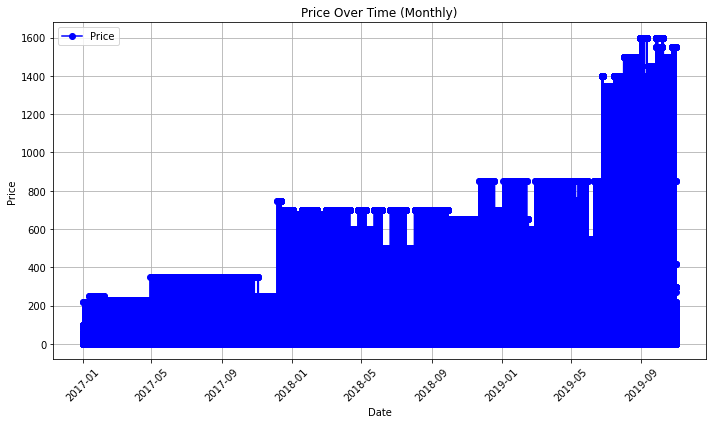

In [43]:

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_sales['date'], df_sales['price'], marker='o', linestyle='-', color='b', label='Price')
plt.title('Price Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()  # Show legend if you have multiple lines

# Display the plot
plt.show()

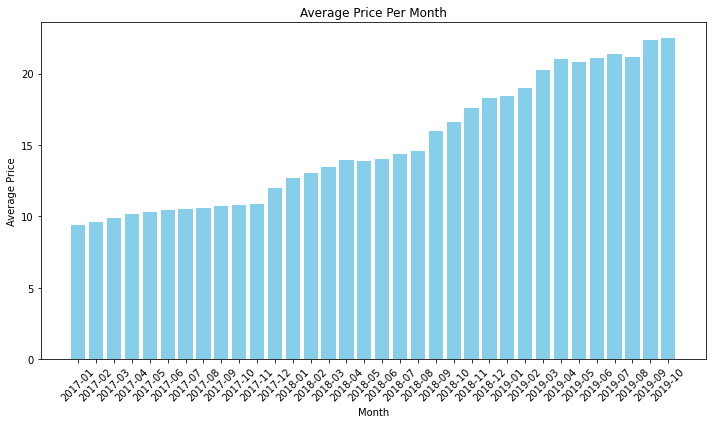

In [44]:
# Group by month and aggregate prices
df_monthly_sales = df_sales.groupby(df_sales['date'].dt.to_period('M')).agg({'price': 'mean'}).reset_index()

# Rename columns if needed
df_monthly_sales.columns = ['month', 'average_price']

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df_monthly_sales['month'].astype(str), df_monthly_sales['average_price'], color='skyblue')
plt.title('Average Price Per Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

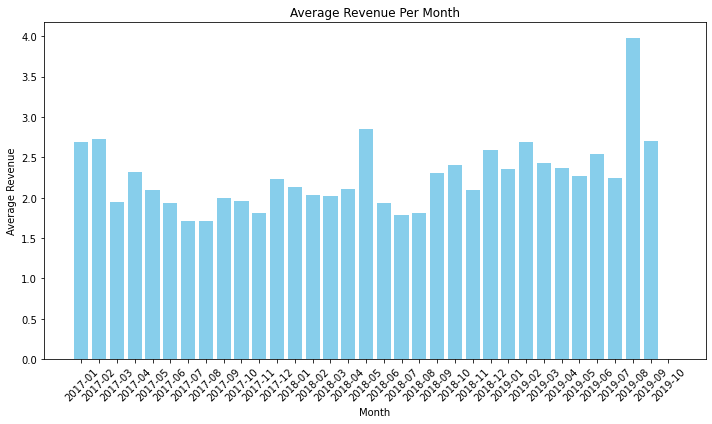

In [48]:
# Group by month and aggregate revenues
df_monthly_sales = df_sales.groupby(df_sales['date'].dt.to_period('M')).agg({'revenue': 'mean'}).reset_index()

# Rename columns if needed
df_monthly_sales.columns = ['month', 'average_revenue']

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df_monthly_sales['month'].astype(str), df_monthly_sales['average_revenue'], color='skyblue')
plt.title('Average Revenue Per Month')
plt.xlabel('Month')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

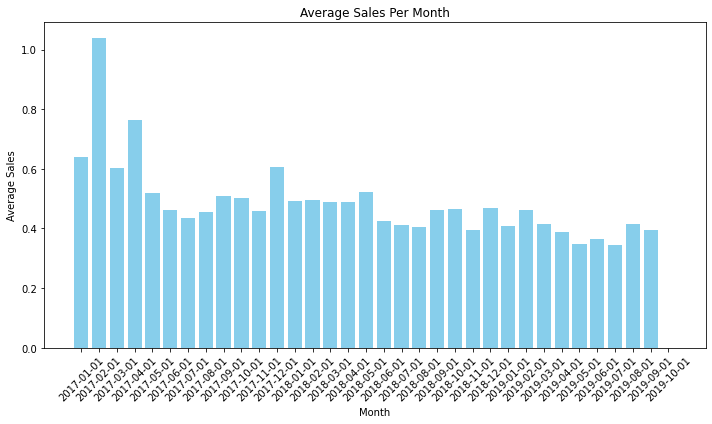

In [50]:
# Group by month and aggregate sales
df_monthly_sales = df_sales.groupby(df_sales['date'].dt.to_period('M')).agg({'sales': 'mean'}).reset_index()

# Rename columns if needed
df_monthly_sales.columns = ['month', 'average_sales']

# Convert 'month' to string format for consistent plotting
df_monthly_sales['month'] = df_monthly_sales['month'].dt.to_timestamp()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df_monthly_sales['month'].astype(str), df_monthly_sales['average_sales'], color='skyblue')
plt.title('Average Sales Per Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

### Add in temporary files to be possible use that in the following notebooks

In [45]:
import joblib

joblib.dump(df_sales, 'df_sales_silver.pkl')
joblib.dump(df_cities, 'df_cities_silver.pkl')
joblib.dump(df_product, 'df_product_silver.pkl')
joblib.dump(df_forecast_revenue, 'df_forecast_revenue_silver.pkl')

['df_forecast_revenue_silver.pkl']